# Results

In [1]:
#import warnings
#warnings.filterwarnings('ignore')
%matplotlib inline
%load_ext autoreload
%autoreload 2
%config Completer.use_jedi = False

In [2]:
import pandas as pd
pd.set_option('display.max_rows', 5000)
pd.set_option('display.max_columns', 5000)
pd.set_option('display.width', 10000)
import numpy as np
import yaml

from vessel_manoeuvring_models.visualization.plot import track_plot, plot
from phd.visualization.plot_ship import track_plots
from vessel_manoeuvring_models.prime_system import PrimeSystem
from phd.visualization.plot_prediction import plot_total_force, plot_force_components, predict, plot_compare_model_forces, plot_parameter_contributions, group_parameters, joined_parameter_contributions, same_ylims
from vessel_manoeuvring_models.symbols import *
import matplotlib.pyplot as plt
from vessel_manoeuvring_models.substitute_dynamic_symbols import run, lambdify, remove_functions, prime
from vessel_manoeuvring_models.parameters import df_parameters
p = df_parameters["symbol"]
import statsmodels.api as sm
import sympy as sp
from sympy import Eq, symbols, latex
import paper
from paper import save_fig, save_eq
import yaml
with open("styles.yml", mode='r') as file:
    styles = yaml.safe_load(file)
from phd.pipelines.predict.nodes import score
import vessel_manoeuvring_models.models.IMO_simulations
from phd.pipelines.load_wPCC.nodes import preprocess,zigzag_angle
from phd.pipelines.resimulate_with_autopilot.nodes import simulate_closed_loop, postprocess

In [3]:
#%reload_kedro
ship='wPCC'
ship_data = catalog.load(f"{ship}.ship_data")

df_VCT = catalog.load(f"{ship}.df_VCT")
resistance_MDL = catalog.load(f"{ship}.resistance_MDL")
tests_ek = catalog.load(f"{ship}.tests_ek2")
tests_ek_smooth = catalog.load(f"{ship}.tests_ek_smooth")


mask = ((df_VCT['Y_R_port'] > 0) & (df_VCT['test type'] == 'self propulsion'))
df_VCT = df_VCT.loc[~mask].copy()  ## remove duplicate self propulsion

time_series_meta_data = catalog.load(f"{ship}.time_series_meta_data")
#tests_ek_smooth_joined = catalog.load(f"{ship}.tests_ek_smooth_joined")
tests_ek_joined = catalog.load(f"{ship}.tests_ek_joined")

df_VCT = catalog.load(f"{ship}.df_VCT")
mask = ((df_VCT['Y_R_port'] > 0) & (df_VCT['test type'] == 'self propulsion'))
df_VCT = df_VCT.loc[~mask].copy()  ## remove duplicate self propulsion


[02/16/24 10:20:45] INFO     Loading data from 'wPCC.ship_data' (YAMLDataSet)...                ]8;id=982152;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=449367;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\

                    INFO     Loading data from 'wPCC.df_VCT' (CSVDataSet)...                    ]8;id=366343;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=925007;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\

                    INFO     Loading data from 'wPCC.resistance_MDL' (CSVDataSet)...            ]8;id=908049;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=399941;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\

                    INFO     Loading data from 'wPCC.tests_ek2' (PartitionedDataset)...         ]8;id=734424;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=948210;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\

                    INFO     Loading data from 'wPCC.tests_ek_smooth' (PartitionedDataset)...   ]8;id=982271;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=418007;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\

                    INFO     Loading data from 'wPCC.time_series_meta_data' (CSVDataSet)...     ]8;id=928596;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=306647;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\

                    INFO     Loading data from 'wPCC.tests_ek_joined' (CSVDataSet)...           ]8;id=644831;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=495283;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\

                    INFO     Loading data from 'wPCC.df_VCT' (CSVDataSet)...                    ]8;id=600406;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=76770;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\

In [4]:
loaders = {
        
    'Reference model' : catalog.load(f"{ship}.models_VCT_MDL")['semiempirical_covered'],
    'Physics informed ID' : catalog.load(f"{ship}.models_ID_hull2")['semiempirical_covered'],
    
    #'Abkowitz VCT': catalog.load(f"{ship}.models_rudder_VCT_MDL")['Abkowitz'],
    'Abkowitz ID' : catalog.load(f"{ship}.models_ID_hull_rudder2")['Abkowitz'],
    #'Martins simple ID' : catalog.load(f"{ship}.models_ID_hull_rudder2")['Martins simple'],


}

                    WARNING  /home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/pa ]8;id=698710;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py\warnings.py]8;;\:]8;id=144424;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py#109\109]8;;\
                             rtitioned_dataset.py:200: KedroDeprecationWarning:                                    
                             'PartitionedDataset' has been moved to `kedro-datasets` and will be                   
                             removed in Kedro 0.19.0.                                                              
                               warnings.warn(                                                                      
                                                                                                                   

                    WARNING  /home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/__ ]8;id=730725;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py\warnings.py]8;;\:]8;id=25838;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py#109\109]8;;\
                             init__.py:44: KedroDeprecationWarning: 'AbstractDataSet' has been                     
                             renamed to 'AbstractDataset', and the alias will be removed in Kedro                  
                             0.19.0                                                                                
                               return getattr(kedro.io.core, name)                                                 
                                                                                                                   

                    INFO     Loading data from 'wPCC.models_VCT_MDL' (PartitionedDataset)...    ]8;id=289631;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=726143;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\

                    INFO     Loading data from 'wPCC.models_ID_hull2' (PartitionedDataset)...   ]8;id=885214;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=528354;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\

                    INFO     Loading data from 'wPCC.models_ID_hull_rudder2'                    ]8;id=149560;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=240564;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\
                             (PartitionedDataset)...                                                               

In [5]:
models = {name:loader() for name,loader in loaders.items()}

In [6]:
#models['Abkowitz VCT'].parameters['Nr']=-0.002195593689997491*1.25
#models['Abkowitz VCT'].parameters['Nrdot']=-0.0001566124359115707*0.3

## Inverse dynamics

In [7]:
model=models['Reference model']

[02/16/24 10:21:12] WARNING  /home/maa/dev/PHD/src/phd/visualization/plot_prediction.py:253:        ]8;id=382486;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py\warnings.py]8;;\:]8;id=489410;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py#109\109]8;;\
                             UserWarning: The figure layout has changed to tight                                   
                               plt.tight_layout()                                                                  
                                                                                                                   

[02/16/24 10:21:13] WARNING  /home/maa/dev/PHD/src/phd/visualization/plot_prediction.py:253:        ]8;id=52335;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py\warnings.py]8;;\:]8;id=677108;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py#109\109]8;;\
                             UserWarning: The figure layout has changed to tight                                   
                               plt.tight_layout()                                                                  
                                                                                                                   

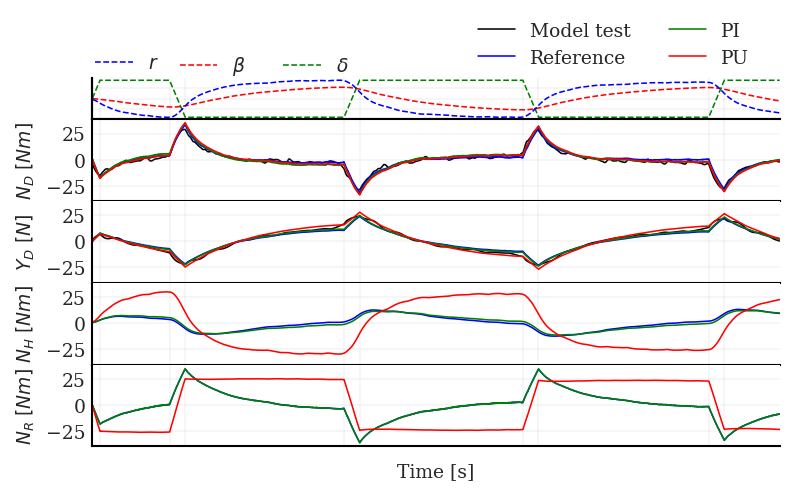

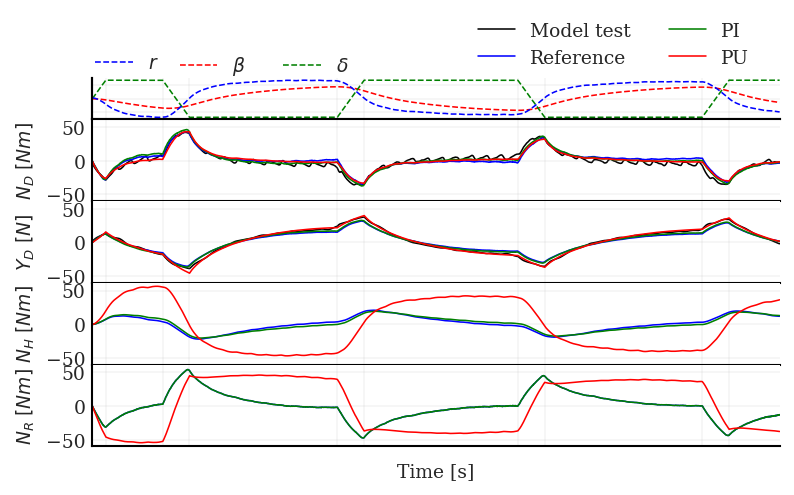

In [8]:
ids = [
    22770,
    22773,
]
for id in ids:
    loader = tests_ek_smooth[str(id)]
    #loader = tests_ek[str(id)]
    data = loader()
    data = preprocess(data,ship_data=ship_data)

    angle = zigzag_angle(data_MDL=data)
    
    fig = plot_compare_model_forces(model=models['Reference model'], models=models, data=data, styles=styles, keys=['N_D','Y_D','N_H','N_R']);
    fig.axes[-1].legend(loc='upper center', bbox_to_anchor=(0.05, 2.0), ncol=1)
    fig.axes[0].legend(loc='upper center', bbox_to_anchor=(0.25, 2.0), ncol=3)
    #fig.axes[1].legend(loc='upper center', bbox_to_anchor=(0.5, 2.52), ncol=2)
    fig.axes[1].legend(bbox_to_anchor=(0.98, 2.4), ncol=2)
    
    #fig = plot_compare_model_forces(model=models['Reference model'], models=models, data=data, styles=styles, keys=['Y_D','Y_H','Y_R']);
    #fig.axes[4].legend(loc='upper center', bbox_to_anchor=(0.3, 2), ncol=1)
    #fig.axes[0].legend(loc='upper center', bbox_to_anchor=(0.5, 2), ncol=3)
    #fig.axes[1].legend(loc='upper center', bbox_to_anchor=(0.5, 1.8), ncol=2)
    #fig.savefig(paper.file_path_with_nb_ref(f"ID_Y_zigzag{int(angle)}.svg"))

    #plt.tight_layout()
    plt.subplots_adjust(wspace=0, hspace=0)
    fig.savefig(paper.file_path_with_nb_ref(f"ID_zigzag{int(angle)}.pdf"),bbox_inches="tight")

## Closed loop simulation

In [9]:
dataframes_all={}

for id in ids:
    loader = tests_ek_smooth[str(id)]
    data = loader()
    data = preprocess(data,ship_data=ship_data)
    angle = zigzag_angle(data_MDL=data)

    dataframes = {
    'Experiment': data,
    }

    for model_name, model in models.items():
        #if 'thrust' in model.control_keys:
        #    model.control_keys.remove('thrust')
        dataframes[model_name] = simulate_closed_loop(model=model,data=data)

    dataframes['Experiment'] = dataframes['Experiment'].loc[0:dataframes['Reference model'].index[-1]].copy()
    
    dataframes['Experiment']['-delta_deg']=-dataframes['Experiment']['delta_deg']
    dataframes_all[angle] = dataframes
    
    

[02/16/24 10:21:25] WARNING  /home/maa/dev/VesselManoeuvringModels/vessel_manoeuvring_models/visual ]8;id=732801;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py\warnings.py]8;;\:]8;id=82308;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py#109\109]8;;\
                             ization/plot.py:127: UserWarning: The figure layout has changed to                    
                             tight                                                                                 
                               plt.tight_layout()                                                                  
                                                                                                                   

                    WARNING  /home/maa/dev/VesselManoeuvringModels/vessel_manoeuvring_models/visual ]8;id=149821;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py\warnings.py]8;;\:]8;id=756131;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py#109\109]8;;\
                             ization/plot.py:127: UserWarning: The figure layout has changed to                    
                             tight                                                                                 
                               plt.tight_layout()                                                                  
                                                                                                                   

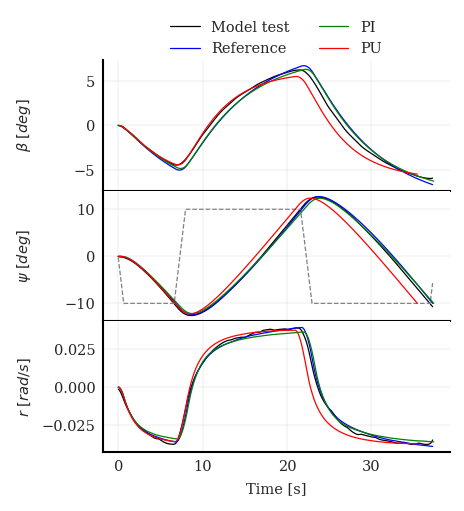

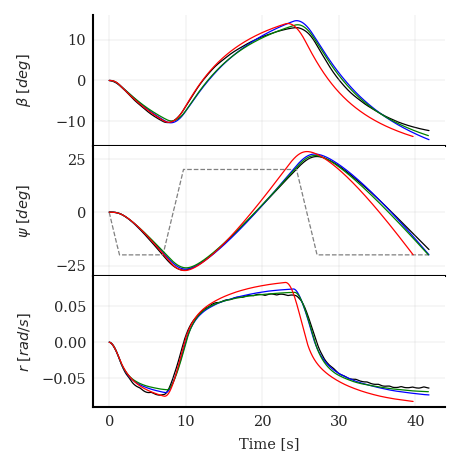

In [10]:
context = {}

context['lines.linewidth'] = 0.60
context['lines.markersize'] = 4
textsize = 7
context["axes.labelsize"] = textsize
context["axes.titlesize"] = textsize
context["legend.fontsize"] = textsize
context["xtick.labelsize"] = textsize
context["ytick.labelsize"] = textsize
first = True
with plt.rc_context(context):
    for angle, dataframes in dataframes_all.items():

        fig = plot(dataframes=dataframes, keys=['beta_deg','r','psi_deg'], styles=styles, ncols=1);
       
        fig.axes[0].get_legend().set_visible(False)
        #fig.axes[1].get_legend().set_visible(False)
        plt.subplots_adjust(wspace=0, hspace=0)
        fig.axes[0].set_ylabel(r'$\beta$ $[deg]$')
        fig.axes[1].set_ylabel(r'$\psi$ $[deg]$')
        fig.axes[1].plot(dataframes['Experiment'].index,dataframes['Experiment']['-delta_deg'],'--',color='gray',zorder=-10)
        fig.axes[2].set_ylabel(r'$r$ $[rad/s]$')

        if first:
            fig.axes[0].legend(loc='upper center', bbox_to_anchor=(0.5, 1.4), ncol=2)
            first = False
            fig.set_size_inches(2.75,3.25*1.0)
        else:
            fig.set_size_inches(2.75,3.25)
        
        #paper.scale_figure(fig=fig, scale=0.5)
        fig.align_ylabels(fig.axes)
        
        fig.savefig(paper.file_path_with_nb_ref(f"closed_loop_zigzag{int(angle)}.svg"),bbox_inches="tight")

## Parameter decomposition
The predicted forces can be decomposed into the various parameter contributions. It can be seen that the `model` and `Abkowitz` have very different decompositions, eventhough the simulations results above are similar. The contributions from the Nr and Nrrr coefficients are very large for the `Abkowitz`.

[02/16/24 10:21:26] WARNING  /tmp/ipykernel_77190/114161799.py:51: UserWarning: This figure was     ]8;id=190538;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py\warnings.py]8;;\:]8;id=414370;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py#109\109]8;;\
                             using a layout engine that is incompatible with subplots_adjust and/or                
                             tight_layout; not calling subplots_adjust.                                            
                               plt.subplots_adjust(wspace=0, hspace=0)                                             
                                                                                                                   

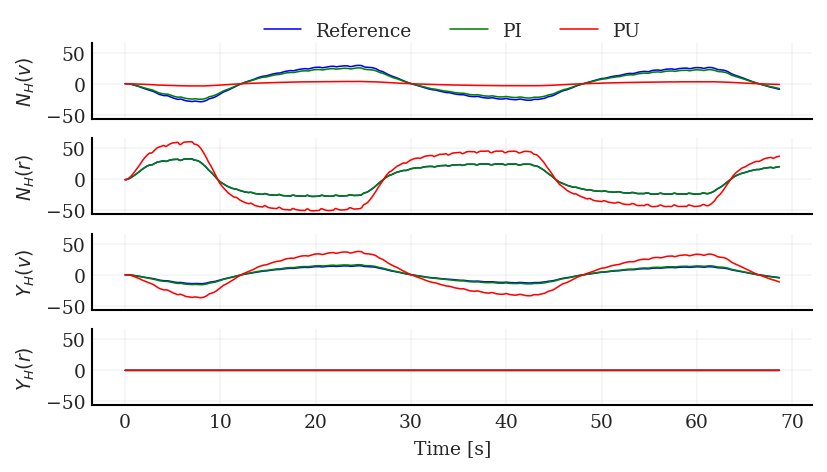

In [11]:
id = 22773
loader = tests_ek[str(id)]
data = loader()
data = preprocess(data,ship_data=ship_data)

model = models['Reference model']
df_joined_parameter_contributions_N = joined_parameter_contributions(model=model, data=data, prefix='N', unit='moment')
df_joined_parameter_contributions_Y = joined_parameter_contributions(model=model, data=data, prefix='Y', unit='force')
df_joined_parameter_contributions = pd.concat((df_joined_parameter_contributions_N,df_joined_parameter_contributions_Y),axis=1)

df_joined_parameter_contributions.drop(columns=['Yvrr+Yvvr','Nvrr+Nvvr'], inplace=True)
renames = {
        'Nv+Nvvv':r'$N_H(v)$',
        'Nr+Nrrr':r'$N_H(r)$',
        'Yv+Yvvv':r'$Y_H(v)$',
        'Yr+Yrrr':r'$Y_H(r)$',
    }
df_joined_parameter_contributions.rename(columns=renames, inplace=True)


fig,axes=plt.subplots(nrows=len(df_joined_parameter_contributions.columns))
for model_name,model in models.items():

    df_joined_parameter_contributions_N = joined_parameter_contributions(model=model, data=data, prefix='N', unit='moment')
    df_joined_parameter_contributions_Y = joined_parameter_contributions(model=model, data=data, prefix='Y', unit='force')
    df_joined_parameter_contributions = pd.concat((df_joined_parameter_contributions_N,df_joined_parameter_contributions_Y),axis=1)
    
    df_joined_parameter_contributions.drop(columns=['Yvrr+Yvvr','Nvrr+Nvvr'], inplace=True)
        
    renames = {
        'Nv+Nvvv':r'$N_H(v)$',
        'Nr+Nrrr':r'$N_H(r)$',
        'Yv+Yvvv':r'$Y_H(v)$',
        'Yr+Yrrr':r'$Y_H(r)$',
    }
    df_joined_parameter_contributions.rename(columns=renames, inplace=True)
    
    for ax,(group_name, values) in zip(axes,df_joined_parameter_contributions.items()):
        values.plot(ax=ax, **styles[model_name])
        ax.set_ylabel(group_name)
        ax.set_xlabel('Time [s]')
        ax.grid(True)

same_ylims(axes)

axes[0].legend(loc='upper center', bbox_to_anchor=(0.5, 1.5), ncol=3)
for ax in axes[0:-1]:
    ax.set_xlabel('')
    ax.set_xticklabels([])

plt.subplots_adjust(wspace=0, hspace=0)
fig.savefig(paper.file_path_with_nb_ref("hull_force_decomposition_zigzag20.svg"))